<a href="https://colab.research.google.com/github/andomn/-traffic-analysis/blob/main/%D0%92%D0%9A%D0%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import sys
import sklearn

In [ ]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/KDDTrain+_2.csv", header=None, names = col_names)
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/KDDTest+_2.csv", header=None, names = col_names)

# изучим размерность данных
print('Размерность обучающего набора:',df.shape)
print('Размерность тестового набора:',df_test.shape)

Размерность обучающего набора: (125973, 42)
Размерность тестового набора: (22544, 42)


In [ ]:
# посмотрим первые 10 строк
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune
6,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,9,1.0,1.0,0.0,0.0,0.05,0.06,0.00,255,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
7,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,16,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune
8,0,tcp,remote_job,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,270,23,1.0,1.0,0.0,0.0,0.09,0.05,0.00,255,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
9,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,8,1.0,1.0,0.0,0.0,0.06,0.06,0.00,255,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune


In [ ]:
# посмотрим основные характеристики данных, такие как среднее значение, минимум, максимум и т.д. 
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df['service'].unique()

array(['ftp_data', 'other', 'private', 'http', 'remote_job', 'name',
       'netbios_ns', 'eco_i', 'mtp', 'telnet', 'finger', 'domain_u',
       'supdup', 'uucp_path', 'Z39_50', 'smtp', 'csnet_ns', 'uucp',
       'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap',
       'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois',
       'imap4', 'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login',
       'kshell', 'sql_net', 'time', 'hostnames', 'exec', 'ntp_u',
       'discard', 'nntp', 'courier', 'ctf', 'ssh', 'daytime', 'shell',
       'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i',
       'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i',
       'http_8001', 'aol', 'http_2784', 'tftp_u', 'harvest'], dtype=object)

In [ ]:
print('Распределение меток обучающего набора:')
print(df['label'].value_counts())
print()
print('Распределение меток тестового набора:')
print(df_test['label'].value_counts())

Распределение меток обучающего набора:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Распределение меток тестового набора:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetat

Для начала нужно провести предварительную обработку данных и преобразовать все категориальные признаки в бинарные. На входе этого преобразователя должна быть матрица целых чисел, обозначающих значения, которые принимают категориальные (дискретные) признаки. На выходе будет получена разреженная матрица, где каждый столбец соответствует одному возможному значению одного признака. Сначала преобразуем каждую категорию в число.


In [ ]:
# столбцы, которые являются категориальными, а не бинарными: protocol_type (столбец 2), service (столбец 3), flag (столбец 4).
print('Обучающий набор:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Признак '{col_name}' имеет {unique_cat} категорий".format(col_name=col_name, unique_cat=unique_cat))


print()
print('Распределение категорий в признаке service:')
print(df['service'].value_counts().sort_values(ascending=False).head())


Обучающий набор:
Признак 'protocol_type' имеет 3 категорий
Признак 'service' имеет 70 категорий
Признак 'flag' имеет 11 категорий
Признак 'label' имеет 23 категорий

Распределение категорий в признаке service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [ ]:
print('Тестовый набор:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Признак '{col_name}' имеет {unique_cat} категорий".format(col_name=col_name, unique_cat=unique_cat))

Тестовый набор:
Признак 'protocol_type' имеет 3 категорий
Признак 'service' имеет 64 категорий
Признак 'flag' имеет 11 категорий
Признак 'label' имеет 38 категорий


Вывод: Необходимо сделать матрицы для всех категорий, так как распределение достаточно равномерное. Всего 84 матрицы (не берем в расчет признак label).
Сравнение результатов показывает, что в тестовом наборе на 6 меньше категорий, их нужно будет добавить как пустые столбцы.

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
# сделаем список с категориальными переменными
categorical_columns=['protocol_type', 'service', 'flag'] 
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [ ]:
# создадим имена столбцов для матриц
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# соединяем
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#делаем тоже самое для тестового набора
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

In [ ]:
# Преобразуем категориальные значения в числовые с помощью LabelEncoder()
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head(10))
# для тестового набора
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9
5              1       49     1
6              1       49     5
7              1       49     5
8              1       51     5
9              1       49     5


In [ ]:
# Применяем One-Hot-Encoding
enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# для тестового набора
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head(10)

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
#  Добавим 6 недостающих категорий в тестовый набор

trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_aol',
 'service_http_2784',
 'service_harvest',
 'service_http_8001',
 'service_red_i',
 'service_urh_i']

In [ ]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

(22544, 84)

Соединим закодированный категориальный датафрейм с некатегориальным

In [ ]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


Разделим набор данных на 4 для каждой категории атак
Переименуем метки каждой атаки: 0=нормальная, 1=DoS, 2=Probe, 3=R2L и 4=U2R.
Заменим столбец меток на новый и создадим новые наборы данных

In [ ]:
# take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64


In [ ]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=newdf[~newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[~newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[~newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[~newdf['label'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[~newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[~newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[~newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[~newdf_test['label'].isin(to_drop_U2R)];
print('Обучающие данные:')
print('Размерность для DoS:' ,DoS_df.shape)
print('Размерность для:' ,Probe_df.shape)
print('Размерность для R2L:' ,R2L_df.shape)
print('Размерность для:' ,U2R_df.shape)
print('Тестовые данные:')
print('Размерность для DoS:' ,DoS_df_test.shape)
print('Размерность для Probe:' ,Probe_df_test.shape)
print('Размерность для R2L:' ,R2L_df_test.shape)
print('Размерность для U2R:' ,U2R_df_test.shape)

Обучающие данные:
Размерность для DoS: (113270, 123)
Размерность для: (78999, 123)
Размерность для R2L: (68338, 123)
Размерность для: (67395, 123)
Тестовые данные:
Размерность для DoS: (17171, 123)
Размерность для Probe: (12132, 123)
Размерность для R2L: (12596, 123)
Размерность для U2R: (9778, 123)


Следующий шаг - нормализация данных

In [ ]:

# Разделим датафрейм на X и Y
# за X возьмем датафрейм признаков, а за Y - итоговую метку

X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label
X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label
X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label
# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

Сохраним список названий характеристик для последующего использования (он одинаков для каждой категории атаки). Имена колонок на этом этапе отбрасываются.

In [ ]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

In [ ]:
# Используем StandardScaler() для нормализации датафрейма
from sklearn import preprocessing
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 
scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)

Проверим, что нормализация прошла успешно и стандартное отклонение равно 1

In [ ]:

print(X_DoS.std(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]


In [ ]:
print(X_Probe.std(axis=0))
print(X_R2L.std(axis=0))
print(X_U2R.std(axis=0))

[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]
[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Перейдем к выбору признаков. Для начала сделаем одномерный отбор признаков с помощью дисперсионного анализа ANOVA (или F-критерий Фишера)

In [ ]:
# использование метода secondPercentile, затем RFE
#Scikit-learn раскрывает процедуры отбора признаков как объекты, реализующие метод преобразования
#SelectPercentile: удаляет все признаки, кроме заданного пользователем процента признаков с наивысшим баллом
#f_classif: F-значение ANOVA между меткой и признаком для задач классификации
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=10)
X_newDoS = selector.fit_transform(X_DoS,Y_DoS)
X_newDoS.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 16  44  63  66  68  86 114] are constant.
  UserWarning)


(113270, 13)

Параметры для DoS

In [ ]:
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
newcolname_DoS=list( colNames[i] for i in newcolindex_DoS )
newcolname_DoS

['logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'service_http',
 'flag_S0',
 'flag_SF']

In [ ]:
X_newProbe = selector.fit_transform(X_Probe,Y_Probe)
X_newProbe.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 16] are constant.
  UserWarning)


(78999, 13)

Параметры для Probe

In [ ]:
true=selector.get_support()
newcolindex_Probe=[i for i, x in enumerate(true) if x]
newcolname_Probe=list( colNames[i] for i in newcolindex_Probe )
newcolname_Probe

['logged_in',
 'rerror_rate',
 'srv_rerror_rate',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'Protocol_type_icmp',
 'service_eco_i',
 'service_private',
 'flag_SF']

In [ ]:
X_newR2L = selector.fit_transform(X_R2L,Y_R2L)
X_newR2L.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  76  77  78  79  80  81  82  83  86  87  89  92
  93  96  98  99 100 107 108 109 110 114] are constant.
  UserWarning)


(68338, 13)

Параметры для R2L

In [ ]:
true=selector.get_support()
newcolindex_R2L=[i for i, x in enumerate(true) if x]
newcolname_R2L=list( colNames[i] for i in newcolindex_R2L)
newcolname_R2L

['src_bytes',
 'dst_bytes',
 'hot',
 'num_failed_logins',
 'is_guest_login',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp',
 'service_ftp_data',
 'service_http',
 'service_imap4',
 'flag_RSTO']

In [ ]:
X_newU2R = selector.fit_transform(X_U2R,Y_U2R)
X_newU2R.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  75  76  77  78  79  80  81  82  83  86  87  89
  92  93  96  98  99 100 107 108 109 110 114] are constant.
  UserWarning)


(67395, 13)

Параметры для U2R

In [ ]:
true=selector.get_support()
newcolindex_U2R=[i for i, x in enumerate(true) if x]
newcolname_U2R=list( colNames[i] for i in newcolindex_U2R)
newcolname_U2R

['urgent',
 'hot',
 'root_shell',
 'num_file_creations',
 'num_shells',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp_data',
 'service_http',
 'service_telnet']

Окончательный список отобранных признаков

In [ ]:
print('Отобранные признаки для DoS:',newcolname_DoS)
print()
print('Отобранные признаки для Probe:',newcolname_Probe)
print()
print('Отобранные признаки для R2L:',newcolname_R2L)
print()
print('Отобранные признаки для U2R:',newcolname_U2R)

Отобранные признаки для DoS: ['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_http', 'flag_S0', 'flag_SF']

Отобранные признаки для Probe: ['logged_in', 'rerror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_icmp', 'service_eco_i', 'service_private', 'flag_SF']

Отобранные признаки для R2L: ['src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'is_guest_login', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp', 'service_ftp_data', 'service_http', 'service_imap4', 'flag_RSTO']

Отобранные признаки для U2R: ['urgent', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'd

Авторы утверждают, что "после получения достаточного количества признаков в процессе одномерного отбора, для определения отобранных признаков использовалось рекурсивное исключение признаков (RFE) с количеством признаков, переданным в качестве параметра". Это означает, что RFE используется только для получения ранее отобранных признаков, но также и для получения ранга. Однако такое использование RFE является избыточным, поскольку отобранные признаки могут быть получены другим способом (Выполнено в данном проекте). Также нельзя сказать, что признаки были отобраны с помощью RFE, так как он для этого не использовался. Однако цитата может означать, что использовалось только число 13, полученное в результате одномерного отбора признаков. Затем RFE используется для отбора признаков, пытаясь найти лучшие 13 признаков. При таком использовании RFE можно сказать, что он был использован для отбора признаков. Однако авторы получили разное количество признаков для каждой категории атак: 12 для DoS, 15 для Probe, 13 для R2L и 11 для U2R. Из этого следует вывод, что неясно, какой механизм используется для отбора признаков.
Чтобы продолжить поиск данных, рассматривается второй вариант, поскольку в нем используется RFE. Теперь количество признаков для каждой категории атак равно 13.


Рекурсивное устранение признаков для ранжирования признаков (Вариант 1: получение важности из предыдущих выбранных)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# создадим классификатор дерева решений
clf = DecisionTreeClassifier(random_state=0)

#проранжируем все признаки, т.е. продолжать отсев до последнего признака
rfe = RFE(clf, n_features_to_select=1)
rfe.fit(X_newDoS, Y_DoS)
print ("DoS отсортирован следующим образом:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))

DoS отсортирован следующим образом:
[(1, 'same_srv_rate'), (2, 'count'), (3, 'flag_SF'), (4, 'dst_host_serror_rate'), (5, 'dst_host_same_srv_rate'), (6, 'dst_host_srv_count'), (7, 'dst_host_count'), (8, 'logged_in'), (9, 'serror_rate'), (10, 'dst_host_srv_serror_rate'), (11, 'srv_serror_rate'), (12, 'service_http'), (13, 'flag_S0')]


In [ ]:
rfe.fit(X_newProbe, Y_Probe)
print ("Probe отсортирован следующим образом:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe отсортирован следующим образом:
[(1, 'dst_host_same_src_port_rate'), (2, 'dst_host_srv_count'), (3, 'dst_host_rerror_rate'), (4, 'service_private'), (5, 'logged_in'), (6, 'dst_host_diff_srv_rate'), (7, 'dst_host_srv_diff_host_rate'), (8, 'flag_SF'), (9, 'service_eco_i'), (10, 'rerror_rate'), (11, 'Protocol_type_icmp'), (12, 'dst_host_srv_rerror_rate'), (13, 'srv_rerror_rate')]


In [ ]:
rfe.fit(X_newR2L, Y_R2L)
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'src_bytes'), (2, 'dst_bytes'), (3, 'hot'), (4, 'dst_host_srv_diff_host_rate'), (5, 'service_ftp_data'), (6, 'dst_host_same_src_port_rate'), (7, 'dst_host_srv_count'), (8, 'num_failed_logins'), (9, 'service_imap4'), (10, 'is_guest_login'), (11, 'service_ftp'), (12, 'flag_RSTO'), (13, 'service_http')]


In [ ]:
rfe.fit(X_newU2R, Y_U2R)
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'hot'), (2, 'dst_host_srv_count'), (3, 'dst_host_count'), (4, 'root_shell'), (5, 'num_shells'), (6, 'service_ftp_data'), (7, 'dst_host_srv_diff_host_rate'), (8, 'num_file_creations'), (9, 'dst_host_same_src_port_rate'), (10, 'service_telnet'), (11, 'srv_diff_host_rate'), (12, 'service_http'), (13, 'urgent')]


2. Рекурсивное исключение признаков, выбор 13 признаков из 122 (Вариант 2: получить 13 лучших признаков из 122 из RFE)¶

In [ ]:

from sklearn.feature_selection import RFE
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)
rfe.fit(X_DoS, Y_DoS)
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)

In [ ]:
rfe.fit(X_Probe, Y_Probe)
X_rfeProbe=rfe.transform(X_Probe)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [ ]:
rfe.fit(X_R2L, Y_R2L)
X_rfeR2L=rfe.transform(X_R2L)
true=rfe.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [ ]:
rfe.fit(X_U2R, Y_U2R)
X_rfeU2R=rfe.transform(X_U2R)
true=rfe.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

Характеристики, отобранные RFE

In [ ]:
print('Отобранные признаки для DoS:',rfecolname_DoS)
print()
print('Отобранные признаки для Probe:',rfecolname_Probe)
print()
print('Отобранные признаки для R2L:',rfecolname_R2L)
print()
print('Отобранные признаки для U2R:',rfecolname_U2R)

Отобранные признаки для DoS: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'same_srv_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i', 'flag_RSTR', 'flag_S0']

Отобранные признаки для Probe: ['src_bytes', 'dst_bytes', 'rerror_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_rerror_rate', 'service_finger', 'service_ftp_data', 'service_http', 'service_private', 'service_smtp', 'service_telnet']

Отобранные признаки для R2L: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'num_access_files', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data', 'service_imap4']

Отобранные признаки для U2R: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_count', 'dst_host_count', 'dst_host

In [ ]:
print(X_rfeDoS.shape)
print(X_rfeProbe.shape)
print(X_rfeR2L.shape)
print(X_rfeU2R.shape)

(113270, 13)
(78999, 13)
(68338, 13)
(67395, 13)


Посторим модель.
Обучим классификатор для всех признаков и для уменьшенных признаков для последующего сравнения.

In [ ]:
# все признаки
clf_DoS=DecisionTreeClassifier(random_state=0)
clf_Probe=DecisionTreeClassifier(random_state=0)
clf_R2L=DecisionTreeClassifier(random_state=0)
clf_U2R=DecisionTreeClassifier(random_state=0)
clf_DoS.fit(X_DoS, Y_DoS)
clf_Probe.fit(X_Probe, Y_Probe)
clf_R2L.fit(X_R2L, Y_R2L)
clf_U2R.fit(X_U2R, Y_U2R)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
# отобранные признаки
clf_rfeDoS=DecisionTreeClassifier(random_state=0)
clf_rfeProbe=DecisionTreeClassifier(random_state=0)
clf_rfeR2L=DecisionTreeClassifier(random_state=0)
clf_rfeU2R=DecisionTreeClassifier(random_state=0)
clf_rfeDoS.fit(X_rfeDoS, Y_DoS)
clf_rfeProbe.fit(X_rfeProbe, Y_Probe)
clf_rfeR2L.fit(X_rfeR2L, Y_R2L)
clf_rfeU2R.fit(X_rfeU2R, Y_U2R)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Следующий шаг - прогнозирование и оценка (валидация):
Использование всех характеристик для каждой категории

Матрица ошибок

DoS

In [ ]:
# Применим классификатор, который мы обучили, к тестовым данным
clf_DoS.predict(X_DoS_test)

array([1, 1, 0, ..., 0, 0, 0])

In [ ]:
# Просмотрим предсказанные вероятности первых 10 наблюдений
clf_DoS.predict_proba(X_DoS_test)[0:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [ ]:
Y_DoS_pred=clf_DoS.predict(X_DoS_test)
# Создадим матрицу ошибок
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9499,212
1,2830,4630


Probe

In [ ]:
Y_Probe_pred=clf_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,2337,7374
2,212,2209


R2L

In [ ]:
Y_R2L_pred=clf_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9707,4
3,2573,312


U2R

In [ ]:
Y_U2R_pred=clf_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9703,8
4,60,7


Кросс-валидация: Accuracy, Precision, Recall, F-measure

DoS

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99639 (+/- 0.00341)
Precision: 0.99505 (+/- 0.00477)
Recall: 0.99665 (+/- 0.00483)
F-measure: 0.99585 (+/- 0.00392)


Probe

In [ ]:
accuracy = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99571 (+/- 0.00328)
Precision: 0.99392 (+/- 0.00684)
Recall: 0.99267 (+/- 0.00405)
F-measure: 0.99329 (+/- 0.00512)


R2L

In [ ]:
accuracy = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97920 (+/- 0.01053)
Precision: 0.97151 (+/- 0.01736)
Recall: 0.96958 (+/- 0.01379)
F-measure: 0.97051 (+/- 0.01478)


U2R

In [ ]:
accuracy = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99652 (+/- 0.00228)
Precision: 0.86295 (+/- 0.08961)
Recall: 0.90958 (+/- 0.09211)
F-measure: 0.88210 (+/- 0.06559)


RFECV

In [ ]:
%matplotlib inline

Automatically created module for IPython interactive environment


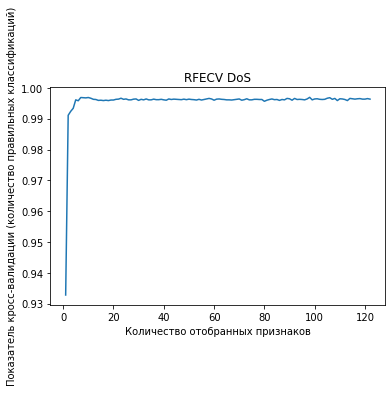

In [ ]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


rfecv_DoS = RFECV(estimator=clf_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_DoS_test, Y_DoS_test)

plt.figure()
plt.xlabel("Количество отобранных признаков")
plt.ylabel("Показатель кросс-валидации (количество правильных классификаций)")
plt.title('RFECV DoS')
plt.plot(range(1, len(rfecv_DoS.grid_scores_) + 1), rfecv_DoS.grid_scores_)
plt.show()

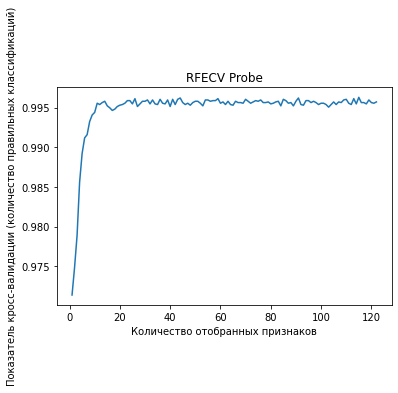

In [ ]:
rfecv_Probe = RFECV(estimator=clf_Probe, step=1, cv=10, scoring='accuracy')
rfecv_Probe.fit(X_Probe_test, Y_Probe_test)

plt.figure()
plt.xlabel("Количество отобранных признаков")
plt.ylabel("Показатель кросс-валидации (количество правильных классификаций)")
plt.title('RFECV Probe')
plt.plot(range(1, len(rfecv_Probe.grid_scores_) + 1), rfecv_Probe.grid_scores_)
plt.show()

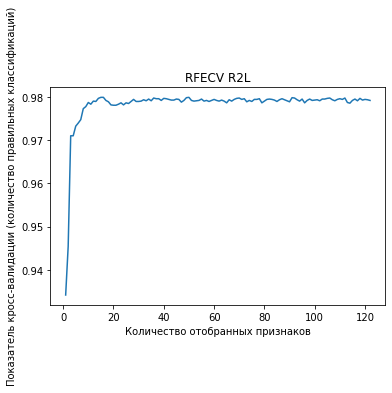

In [ ]:
rfecv_R2L = RFECV(estimator=clf_R2L, step=1, cv=10, scoring='accuracy')
rfecv_R2L.fit(X_R2L_test, Y_R2L_test)

plt.figure()
plt.xlabel("Количество отобранных признаков")
plt.ylabel("Показатель кросс-валидации (количество правильных классификаций)")
plt.title('RFECV R2L')
plt.plot(range(1, len(rfecv_R2L.grid_scores_) + 1), rfecv_R2L.grid_scores_)
plt.show()

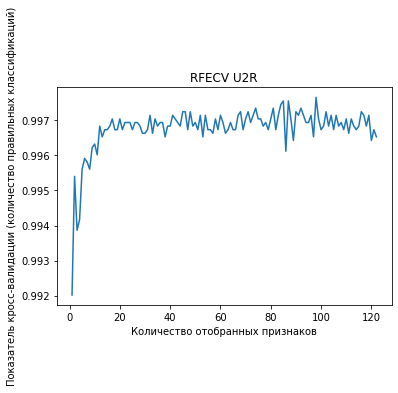

In [ ]:
rfecv_U2R = RFECV(estimator=clf_U2R, step=1, cv=10, scoring='accuracy')
rfecv_U2R.fit(X_U2R_test, Y_U2R_test)

plt.figure()
plt.xlabel("Количество отобранных признаков")
plt.ylabel("Показатель кросс-валидации (количество правильных классификаций)")
plt.title('RFECV U2R')
plt.plot(range(1, len(rfecv_U2R.grid_scores_) + 1), rfecv_U2R.grid_scores_)
plt.show()

Используем 13 признаков для каждой категории

Построим матрицы ошибок

DoS

In [ ]:
# сократим набор тестовых данных до 13 признаков, и используем только признаки, описанные в rfecolname_DoS и т.д.
X_DoS_test2=X_DoS_test[:,rfecolindex_DoS]
X_Probe_test2=X_Probe_test[:,rfecolindex_Probe]
X_R2L_test2=X_R2L_test[:,rfecolindex_R2L]
X_U2R_test2=X_U2R_test[:,rfecolindex_U2R]
X_U2R_test2.shape

(9778, 13)

In [ ]:
Y_DoS_pred2=clf_rfeDoS.predict(X_DoS_test2)
# Создадим матрицу ошибок
pd.crosstab(Y_DoS_test, Y_DoS_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9602,109
1,2625,4835


Probe

In [ ]:
Y_Probe_pred2=clf_rfeProbe.predict(X_Probe_test2)
pd.crosstab(Y_Probe_test, Y_Probe_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,8709,1002
2,944,1477


R2L

In [ ]:
Y_R2L_pred2=clf_rfeR2L.predict(X_R2L_test2)
pd.crosstab(Y_R2L_test, Y_R2L_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9649,62
3,2560,325


U2R

In [ ]:
Y_U2R_pred2=clf_rfeU2R.predict(X_U2R_test2)
pd.crosstab(Y_U2R_test, Y_U2R_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9706,5
4,52,15


Кросс-валидация: Accuracy, Precision, Recall, F-measure

DoS

In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99738 (+/- 0.00267)
Precision: 0.99692 (+/- 0.00492)
Recall: 0.99705 (+/- 0.00356)
F-measure: 0.99698 (+/- 0.00307)


Probe

In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99085 (+/- 0.00559)
Precision: 0.98674 (+/- 0.01179)
Recall: 0.98467 (+/- 0.01026)
F-measure: 0.98566 (+/- 0.00871)


R2L

In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97459 (+/- 0.00910)
Precision: 0.96689 (+/- 0.01311)
Recall: 0.96086 (+/- 0.01571)
F-measure: 0.96379 (+/- 0.01305)


U2R

In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99652 (+/- 0.00278)
Precision: 0.87538 (+/- 0.15433)
Recall: 0.89540 (+/- 0.14777)
F-measure: 0.87731 (+/- 0.09647)


In [ ]:
from sklearn.model_selection import StratifiedKFold
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99738 (+/- 0.00267)


In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99085 (+/- 0.00559)


In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97459 (+/- 0.00910)


In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99652 (+/- 0.00278)


CV 2, 5, 10, 30, 50 раз

DoS

In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99662 (+/- 0.00116)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99709 (+/- 0.00064)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99738 (+/- 0.00267)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99726 (+/- 0.00430)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99703 (+/- 0.00622)


Probe

In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99060 (+/- 0.00165)


In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99093 (+/- 0.00233)


In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99085 (+/- 0.00559)


In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99118 (+/- 0.00742)


In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99085 (+/- 0.01122)


R2L

In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97118 (+/- 0.00143)


In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97388 (+/- 0.00624)


In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97459 (+/- 0.00910)


In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97467 (+/- 0.01644)


In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97523 (+/- 0.01795)


U2R

In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99519 (+/- 0.00184)


In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99714 (+/- 0.00153)


In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99652 (+/- 0.00278)


In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99693 (+/- 0.00571)


In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99662 (+/- 0.00755)
